In [1]:
!ls

classifiers_mhcld.ipynb
codebook_descriptions.pickle
google_colab_t-sne_mental_health_client-level_data.ipynb
mhcld_puf_2021.csv
plots
t-sne_mental_health_client-level_data.ipynb
to_do.txt


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv("mhcld_puf_2021.csv")
NUM_POINTS = 10_000
data = data[:NUM_POINTS]

In [4]:
# Load data the codebook descriptions
import pickle
with open('codebook_descriptions.pickle', 'rb') as handle:
    codebook_descriptions = pickle.load(handle)
assert set(list(data.columns)) == set(list(codebook_descriptions.keys()))

In [5]:
#columns to drop. reasoning in t-sne notebook.
drop_cols = ['YEAR','CASEID','SUB','MH1','MH2','MH3','SMISED','DETNLF','NUMMHS','STATEFIP','REGION','DIVISION']
data = data.drop(columns = drop_cols)

In [6]:
#disorder columns. 0/1 binary. these are dignoses for the disorders
disorder_cols = ['TRAUSTREFLG','ANXIETYFLG','ADHDFLG','CONDUCTFLG','DELIRDEMFLG','BIPOLARFLG','DEPRESSFLG','ODDFLG','PDDFLG','SCHIZOFLG','PERSONFLG','ALCSUBFLG','OTHERDISFLG']

In [7]:
#columns which require a transformation to standardize to 0-1. reasoning in t-sne notebook.
transform_cols = ['AGE','EDUC','GENDER','SPHSERVICE','CMPSERVICE','OPISERVICE','RTCSERVICE','IJSSERVICE','SAP','VETERAN ']
max_age = max(data['AGE'])
max_educ = max(data['EDUC'])
data['AGE'] = data['AGE'].apply(lambda x: x/max_age)
data['EDUC'] = data['EDUC'].apply(lambda x: 0 if x==-9 else x/max_educ)
data['GENDER'] = data['GENDER'].apply(lambda x: .5 if x==-9 else x-1)
data['SAP'] = data['SAP'].apply(lambda x: .5 if x==-9 else x-1)
data['VETERAN'] = data['VETERAN'].apply(lambda x: .5 if x==-9 else x-1)
data['SPHSERVICE'] = data['SPHSERVICE'].apply(lambda x: x-1)
data['CMPSERVICE'] = data['CMPSERVICE'].apply(lambda x: x-1)
data['OPISERVICE'] = data['OPISERVICE'].apply(lambda x: x-1)
data['RTCSERVICE'] = data['RTCSERVICE'].apply(lambda x: x-1)
data['IJSSERVICE'] = data['IJSSERVICE'].apply(lambda x: x-1)

In [8]:
#categorical columns w/ more than two categorices
#encode them with one-hot encoding
from sklearn.preprocessing import OneHotEncoder
one_hot_cols = ['ETHNIC','RACE','MARSTAT','EMPLOY','LIVARAG']
one_hot_enc=OneHotEncoder().fit(data[one_hot_cols])
one_hot_categorical_data = one_hot_enc.transform(data[one_hot_cols]).toarray()
one_hot_feature_names=list(one_hot_enc.get_feature_names_out(['ETHNIC','RACE','MARSTAT','EMPLOY','LIVARAG']))
one_hot_encoded_df = pd.DataFrame(data=one_hot_categorical_data,columns=one_hot_feature_names)
print(sum(len(item) for item in one_hot_enc.categories_))
data = data.drop(columns=one_hot_cols)
data = data.join(one_hot_encoded_df)
print(data.shape)

26
(10000, 49)


In [12]:
#could just map 0/1 string to binary number
#too many categories. need to reduce
#so create a label for those which are purely 1 for some disorder, and 0 for all others
#use separate category for uncategorized data
#use this as a hue to color the graph
labels = []
for row in data[disorder_cols][:NUM_POINTS].itertuples():
  #binary number encoding of disorders
  #labels.append(sum(row[1][i]*2**i for i in range(len(data.columns))))
  #sum the total number of disorders
  #labels.append(sum(row[1][i] for i in range(len(disorder_cols))))
  #unique labels for pure disorders, separate categories for multiple or no disorders
  num_disorders = sum(row[i] for i in range(1,len(row)))
  if num_disorders == 0:
    #labels.append(0)
    labels.append('no_disorder')
  if num_disorders == 1:
    #get the index (string) of the column with value 1
    labels.append(disorder_cols[list(row)[1:].index(1)])
  if num_disorders > 1:
    #labels.append(len(data.columns)+1)
    labels.append('multi-disorder')

label_df = pd.DataFrame(labels,columns=['label'])

In [57]:
#data_labeled = label_df.merge(data, left_index=True, right_index=True)

In [10]:
#k-means labeling
from sklearn.cluster import KMeans
NUM_CLUSTERS = 13
kmeans = KMeans(n_clusters=NUM_CLUSTERS, init='k-means++', max_iter=300, random_state=0, n_init=10)
kmeans.fit(data)
kmeans_label_df = pd.DataFrame(kmeans.labels_,columns=['label'])

In [ ]:
#tsne_results_kmeans_label = kmeans_label_df.merge(data, left_index=True, right_index=True)

In [97]:
#PERFORM CLASSIFICATION
#may have unbalanced classes, too many in multi-disorder

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

In [40]:
X = data.drop(columns=disorder_cols)
y = np.squeeze(label_df)

In [41]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [42]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [43]:
y_pred_rf = rf.predict(X_test)

In [44]:
#17% accuracy on multi-disorder-labeled data
#36% accuracy on unique-disorder-labeled data 
accuracy = accuracy_score(y_test, y_pred_rf)
print("Accuracy:", accuracy)
precision = precision_score(y_test, y_pred_rf, average='weighted')
print("Precision:", precision)
recall = recall_score(y_test, y_pred_rf, average='weighted')
print("Recall:", recall)

Accuracy: 0.3255
Precision: 0.2837650812792641
Recall: 0.3255


/Users/jacksonwalters/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jacksonwalters/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
vis_arr = multilabel_confusion_matrix(y_test, y_pred_rf)

In [25]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("CFS_MATRIX for " + class_label)

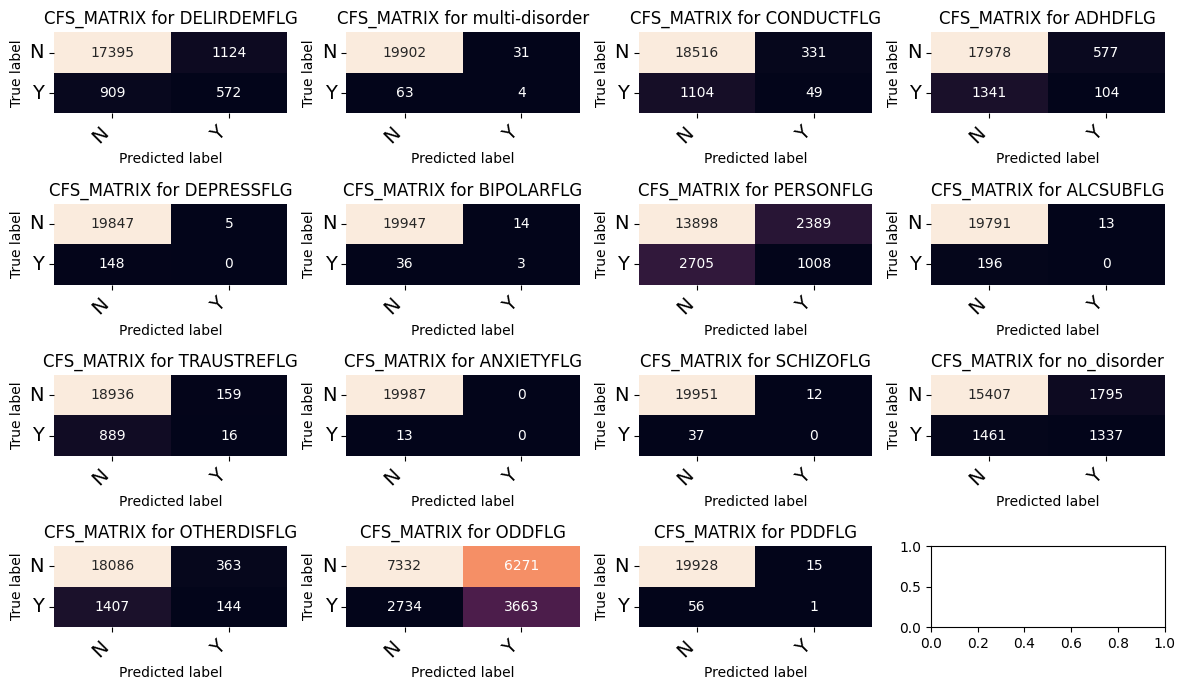

In [99]:
fig, ax = plt.subplots(4, 4, figsize=(12, 7))
    
for axes, cfs_matrix, label in zip(ax.flatten(), vis_arr, list(set(labels))):
    print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
    
fig.tight_layout()
fig.savefig("./plots/confusion_matrix_mhcld_unique-disorder-label.png")
plt.show()

In [110]:
#MULTI-CLASS LOGISTIC REGRESSION

In [26]:
from sklearn.linear_model import LogisticRegression

In [45]:
clf = LogisticRegression(solver='lbfgs', max_iter=3000).fit(X_train, y_train)

In [46]:
y_pred_logistic = clf.predict(X_test)

In [47]:
accuracy = accuracy_score(y_test, y_pred_logistic)
print("Accuracy:", accuracy)
precision = precision_score(y_test, y_pred_logistic, average='weighted')
print("Precision:", precision)
recall = recall_score(y_test, y_pred_logistic, average='weighted')
print("Recall:", recall)

Accuracy: 0.369
Precision: 0.2667028787537542
Recall: 0.369


/Users/jacksonwalters/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
#MULTI-CLASS LOGISTIC REGRESSION w/ K-MEAN LABELS

In [48]:
X = data.drop(columns=disorder_cols)
y = np.squeeze(kmeans_label_df)

In [49]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [50]:
clf = LogisticRegression(solver='lbfgs', max_iter=3000).fit(X_train, y_train)

In [51]:
y_pred_logistic_kmeans = clf.predict(X_test)

In [52]:
accuracy = accuracy_score(y_test, y_pred_logistic_kmeans)
print("Accuracy:", accuracy)
precision = precision_score(y_test, y_pred_logistic_kmeans, average='weighted')
print("Precision:", precision)
recall = recall_score(y_test, y_pred_logistic_kmeans, average='weighted')
print("Recall:", recall)

Accuracy: 0.926
Precision: 0.9222371300764367
Recall: 0.926
